<a href="https://colab.research.google.com/github/Minatozaki0911/summerIntern203/blob/master/COVID_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!pip install keras

In [ ]:
 import keras
 from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
 from keras.models import Model, Sequential
 from keras.preprocessing.image import ImageDataGenerator
 from keras.models import load_model
 from keras.utils.vis_utils import plot_model
 import numpy as np
 import matplotlib.pyplot as plt

In [ ]:
IMAGE_SIZE = (224,224)
BATCH_SIZE = 32

In [ ]:
train_path = '/content/drive/MyDrive/Dataset/CT_COVID'
test_path = '/content/drive/MyDrive/Colab Notebooks/'

In [ ]:
# DATA PREPARATION
train_datagen = ImageDataGenerator(rescale=1./255,
                             shear_range=0.1,
                             zoom_range=0.1,
                             horizontal_flip=True,
                             validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(train_path, 
                                               target_size=(224,224),
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='training')

validation_generator = train_datagen.flow_from_directory(train_path, 
                                               target_size=IMAGE_SIZE,
                                               batch_size=BATCH_SIZE,
                                               color_mode='grayscale',
                                               class_mode='binary',
                                               shuffle=True,
                                               subset='validation')

test_generator = test_datagen.flow_from_directory(test_path,
                                                  target_size=(224, 224),
                                                  color_mode="grayscale",
                                                  classes=['test'],
                                                  class_mode='binary',
                                                  batch_size=1,
                                                  shuffle=False)
print(test_generator.filenames)

Found 1986 images belonging to 2 classes.
Found 495 images belonging to 2 classes.
Found 9 images belonging to 1 classes.
['test/covid-19-pneumonia-182.jpg', 'test/covid-19-pneumonia-30.jpg', 'test/covid-19-pneumonia-56.jpg', 'test/covid-19-pneumonia-94.png', 'test/normal-chest-ct-1 (1).jpg', 'test/normal-chest-ct-1 (2).jpg', 'test/normal-chest-ct-1 (3).jpg', 'test/normal-chest-ct-1 (4).png', 'test/normal-chest-ct-1 (5).jpg']


In [ ]:
def VGG16():
  model = Sequential()
  model.add(Conv2D(16, 3, padding='same', activation='relu', input_shape=(224,224,1)))
  model.add(Conv2D(16, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(Conv2D(32, 3, padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(1, activation='sigmoid'))
  return model

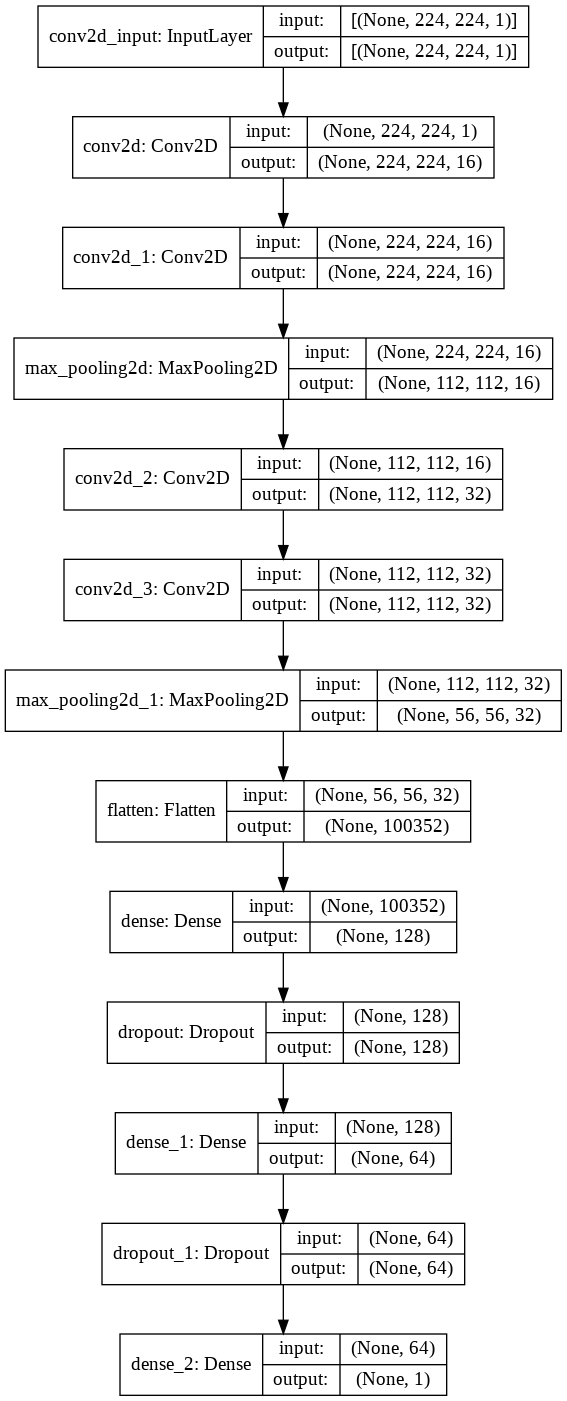

In [ ]:
model = VGG16()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.9, staircase=True
)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
              loss='binary_crossentropy',
              metrics=['acc'])

In [ ]:
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "COVID_VGG16_checkpoint.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

In [12]:
# TRAIN MODEL
history = model.fit(train_generator, 
                    validation_data=validation_generator,
                    shuffle=True,
                    epochs=20,
                    verbose=1,
                    callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/20
63/63 [==============================] - 237s 3s/step - loss: 0.6947 - acc: 0.5279 - val_loss: 0.6715 - val_acc: 0.5333
Epoch 2/20
63/63 [==============================] - 220s 3s/step - loss: 0.6489 - acc: 0.6120 - val_loss: 0.5254 - val_acc: 0.7374
Epoch 3/20
63/63 [==============================] - 219s 3s/step - loss: 0.5292 - acc: 0.7446 - val_loss: 0.4804 - val_acc: 0.7434
Epoch 4/20
63/63 [==============================] - 220s 3s/step - loss: 0.4596 - acc: 0.7978 - val_loss: 0.4728 - val_acc: 0.7717
Epoch 5/20
63/63 [==============================] - 220s 3s/step - loss: 0.4456 - acc: 0.8017 - val_loss: 0.4477 - val_acc: 0.7778
Epoch 6/20
63/63 [==============================] - 220s 3s/step - loss: 0.3885 - acc: 0.8501 - val_loss: 0.4758 - val_acc: 0.7657
Epoch 7/20
63/63 [==============================] - 219s 3s/step - loss: 0.3681 - acc: 0.8508 - val_loss: 0.4548 - val_acc: 0.7778
Epoch 8/20
63/63 [==============================] - 221s 4s/step - loss: 0.3627 - a

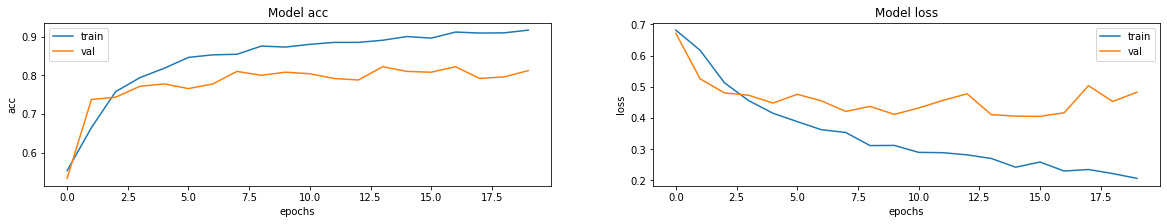

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [14]:
model.evaluate(test_generator)

9/9 [==============================] - 3s 350ms/step - loss: 0.6684 - acc: 0.7778


[0.6684064269065857, 0.7777777910232544]

In [15]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks')
model.save("COVID_VGG16_Model")         #Model folder contain .pb file
model.save("COVID_VGG16.h5")            #HDF5 format for custom use

INFO:tensorflow:Assets written to: COVID_VGG16_Model/assets


In [16]:
new_model = load_model("/content/drive/MyDrive/Colab Notebooks/COVID_VGG16_Model", compile=True)
predictions = new_model.predict(test_generator)
for i in range(0, (test_generator.labels.shape[0])):
  if predictions[i] > 0.005:
    print(test_generator.filenames[i] + 'is normal')
  else:
    print(test_generator.filenames[i] + 'is COVID')

test/covid-19-pneumonia-182.jpgis COVID
test/covid-19-pneumonia-30.jpgis COVID
test/covid-19-pneumonia-56.jpgis normal
test/covid-19-pneumonia-94.pngis COVID
test/normal-chest-ct-1 (1).jpgis COVID
test/normal-chest-ct-1 (2).jpgis normal
test/normal-chest-ct-1 (3).jpgis normal
test/normal-chest-ct-1 (4).pngis normal
test/normal-chest-ct-1 (5).jpgis normal
